# Factor Allocation Strategy

**Point-in-Time FRED-MD** macroeconomic data to predict factor allocation.

**Model**: MICRO Transformer (12k params)

## Rigorous Evaluation Methodology

```
┌─────────────────────────────────────────────────────────────────┐
│ STEP 1: WALK-FORWARD (2017-2022)                                │
│   - Train N models on expanding windows                         │
│   - Test each on 1 year OOS (non-overlapping)                   │
│   - HOLDOUT: 2023-2024 reserved (no model sees these)           │
│   - Save all N models for ensemble                              │
└─────────────────────────────────────────────────────────────────┘
                              ↓
┌─────────────────────────────────────────────────────────────────┐
│ STEP 2: FINAL MODEL                                             │
│   - Train on 2000-2022 (all data except holdout)                │
│   - Single model for production use                             │
└─────────────────────────────────────────────────────────────────┘
                              ↓
┌─────────────────────────────────────────────────────────────────┐
│ STEP 3: HOLDOUT EVALUATION (2023-2024)                          │
│   - Evaluate FINAL model on 2023-2024                           │
│   - Evaluate ENSEMBLE (avg of N models) on 2023-2024            │
│   - Compare robustness: Final vs Ensemble                       │
└─────────────────────────────────────────────────────────────────┘
```

## 16 Combinations

| Strategy | Allocation | Horizons |
|----------|------------|-----------|
| E2E (3-phase) | Binary (2F) | 1M, 3M, 6M, 12M |
| E2E (3-phase) | Multi (6F) | 1M, 3M, 6M, 12M |
| Supervised | Binary (2F) | 1M, 3M, 6M, 12M |
| Supervised | Multi (6F) | 1M, 3M, 6M, 12M |

**Key**: All models rebalance monthly. Horizon = Sharpe optimization target.

In [1]:
# ============================================================
# SETUP
# ============================================================

%matplotlib inline

import sys
import warnings
from pathlib import Path

warnings.filterwarnings('ignore')

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / "src"))

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

np.random.seed(42)
torch.manual_seed(42)

print("Setup complete")

Setup complete


In [2]:
# ============================================================
# DATA LOADING
# ============================================================

from data.point_in_time_loader import PointInTimeFREDMDLoader, PointInTimeConfig
from data.factor_data_loader import FactorDataLoader, FactorDataConfig
from data.data_loader import Region
from features.feature_engineering import FeatureEngineer, FeatureConfig

# Load Point-in-Time FRED-MD
vintages_dir = project_root / "data_cache" / "vintages"

pit_loader = PointInTimeFREDMDLoader(
    PointInTimeConfig(
        vintages_dir=vintages_dir,
        publication_lag=1,
        apply_transformations=True
    )
)

macro_data = pit_loader.create_pit_macro_dataframe(
    start_date="2000-01-01",
    end_date="2024-12-31"
)

market_data = pit_loader.create_pit_market_context(
    start_date="2000-01-01",
    end_date="2024-12-31"
)

indicators = pit_loader.get_indicators()

# Load factor returns
factor_loader = FactorDataLoader(
    FactorDataConfig(
        start_date="2000-01-01",
        end_date="2024-12-31",
        cache_dir=project_root / "data_cache" / "factors",
        use_cache=True
    )
)

factor_data = factor_loader.load_all_factors()

print(f"\nData loaded: {len(macro_data)} macro obs, {len(factor_data)} factor obs")

Indexed 305 vintage files
  Coverage: 1999-08 to 2024-12
Loading cached all factors from /Users/mathis/Finance-Quant-thinking/Strategies/factor_allocation_strategy_macro/data_cache/factors/all_factors.parquet

Data loaded: 32799 macro obs, 288 factor obs


---
## Model Configuration

In [3]:
# ============================================================
# CONFIGURATION
# ============================================================

# MICRO Transformer (12k params - reduced to prevent overfitting)
CONFIG = {
    # Architecture
    "sequence_length": 12,
    "num_factors": 6,
    "d_model": 32,
    "num_heads": 1,
    "num_layers": 1,
    "d_ff": 64,
    "dropout": 0.6,
    
    # Training
    "learning_rate": 0.001,
    "batch_size": 32,
    "weight_decay": 0.02,
    "epochs_phase1": 20,
    "epochs_phase2": 15,
    "epochs_phase3": 15,
    
    # Backtest
    "execution_threshold": 0.05,
    "transaction_cost": 0.001,
    "val_split": 0.2,
}

# Feature engineering
feature_config = FeatureConfig(
    sequence_length=12,
    include_momentum=True,
    include_market_context=True,
    use_fred_md=True,
    aggregation_windows=[1, 3, 6, 12]
)

feature_engineer = FeatureEngineer(
    config=feature_config,
    region=Region.US,
    fred_md_indicators=indicators
)

print(f"Model: d_model={CONFIG['d_model']}, layers={CONFIG['num_layers']}, heads={CONFIG['num_heads']}")
print(f"Features: {feature_engineer.get_num_indicators()} indicators")

Model: d_model=32, layers=1, heads=1
Features: 112 indicators


---
## Feature Selection & PCA (Optional)

Reduce dimensionality from 112 indicators to improve generalization.

In [4]:
# ============================================================
# FEATURE SELECTION & PCA DEMO
# ============================================================

from features.feature_selection import (
    IndicatorSelector,
    PCAFeatureReducer,
    SelectionConfig,
    PCAConfig,
)

# Create target data for 1M horizon
target_1m = factor_loader.create_binary_target(factor_data, horizon_months=1)

# --- OPTION 1: Indicator Selection (Mutual Information) ---
print("=" * 60)
print("INDICATOR SELECTION (Mutual Information)")
print("=" * 60)

selector = feature_engineer.create_indicator_selector(
    macro_data=macro_data,
    target_data=target_1m,
    method="mutual_info",
    n_features=30,  # Keep top 30 indicators
)

# Show top indicators
rankings = selector.get_indicator_rankings()
print(f"\nTop 10 indicators (out of {len(rankings)}):")
print(rankings.head(10).to_string(index=False))

# Apply selection
macro_filtered = feature_engineer.apply_indicator_selection(macro_data, selector)
print(f"\nFiltered: {len(macro_data)} -> {len(macro_filtered)} observations")
print(f"Unique indicators: {macro_data['indicator'].nunique()} -> {macro_filtered['indicator'].nunique()}")

# --- OPTION 2: PCA on Flat Features ---
print("\n" + "=" * 60)
print("PCA DIMENSIONALITY REDUCTION")
print("=" * 60)

pca_reducer = feature_engineer.create_pca_reducer(
    macro_data=macro_data,
    factor_data=factor_data,
    market_data=market_data,
    target_data=target_1m,
    n_components=20,  # Keep 20 components
)

variance_ratio, total_var = pca_reducer.get_explained_variance()
print(f"\nPCA: {len(variance_ratio)} components -> {total_var:.1%} variance explained")
print(f"Top 5 components: {variance_ratio[:5].round(3)}")

# Example: Get PCA-reduced features for one date
sample_date = target_1m.iloc[100]["timestamp"]
pca_features = feature_engineer.create_flat_features_with_pca(
    macro_data, factor_data, market_data, sample_date, pca_reducer
)
print(f"\nExample: date={sample_date.date()}")
print(f"  Original features: ~100 -> PCA features: {len(pca_features)}")


Created binary targets: 287 observations
Target distribution:
target
1    149
0    138
Name: count, dtype: int64
INDICATOR SELECTION (Mutual Information)

Top 10 indicators (out of 112):
    indicator    score  selected  rank
       HOUSTW 0.051255      True     1
CES0600000008 0.044960      True     2
       T1YFFM 0.044825      True     3
       INVEST 0.043641      True     4
       USGOOD 0.041941      True     5
        CP3Mx 0.040196      True     6
     TOTRESNS 0.039409      True     7
      T10YFFM 0.038820      True     8
  CUSR0000SAS 0.034391      True     9
  CUSR0000SAD 0.033069      True    10

Filtered: 32799 -> 8645 observations
Unique indicators: 112 -> 30

PCA DIMENSIONALITY REDUCTION

PCA: 20 components -> 87.8% variance explained
Top 5 components: [0.118 0.11  0.08  0.066 0.065]

Example: date=2008-05-01
  Original features: ~100 -> PCA features: 20


---
## Walk-Forward Hyperparameter Tuning (Optional)

Tune hyperparameters **before training** using walk-forward validation:
- Respects temporal order (no look-ahead bias)
- Uses Bayesian optimization (Optuna) or random search
- Optimizes validation Sharpe ratio

If enabled, tuned parameters will be used for the 16-combination training below.

In [5]:
# ============================================================
# WALK-FORWARD HYPERPARAMETER TUNING (OPTIONAL)
# ============================================================
# Set RUN_TUNING = True to enable (takes ~10-15 min with 15 trials)

RUN_TUNING = False  # Default: OFF (set True to enable HP tuning)
USE_FEATURE_SELECTION = False  # Default: OFF (set True to reduce features)
N_TRIALS = 15  # Number of trials per window (if tuning enabled)

# Prepare target data for tuning
from comparison_runner import prepare_data
targets, cumulative_returns = prepare_data(factor_loader, factor_data)

if RUN_TUNING:
    from comparison_runner import run_with_tuning
    
    # Tune on 3M horizon (best performing)
    target_3m = targets[3]
    
    print("Running walk-forward HP tuning...")
    print("This will find optimal hyperparameters for each temporal window.\n")
    
    tuning_summary, tuning_results = run_with_tuning(
        macro_data=macro_data,
        factor_data=factor_data,
        market_data=market_data,
        target_data=target_3m,
        indicators=indicators,
        feature_engineer=feature_engineer,
        config=CONFIG,
        strategy="supervised",
        n_trials=N_TRIALS,
        optimization_metric="sharpe",
        verbose=True,
    )
    
    # Update CONFIG with tuned parameters
    TUNED_CONFIG = CONFIG.copy()
    best_params = tuning_summary.get("best_params", {})
    for key, value in best_params.items():
        if key in TUNED_CONFIG:
            TUNED_CONFIG[key] = value
    
    print("\n" + "=" * 60)
    print("TUNED CONFIGURATION (will be used for training)")
    print("=" * 60)
    for k in ["learning_rate", "dropout", "weight_decay", "batch_size",
              "epochs_phase1", "epochs_phase2", "epochs_phase3"]:
        old_val = CONFIG.get(k)
        new_val = TUNED_CONFIG.get(k)
        changed = " <- TUNED" if old_val != new_val else ""
        print(f"  {k}: {new_val}{changed}")
else:
    TUNED_CONFIG = CONFIG.copy()
    print("Walk-forward tuning disabled. Using default CONFIG.")
    print("Set RUN_TUNING = True to enable hyperparameter tuning.")


Horizon 1M: 287 observations
  Target distribution: {1: np.int64(149), 0: np.int64(138)}

Horizon 3M: 285 observations
  Target distribution: {1: np.int64(154), 0: np.int64(131)}

Horizon 6M: 282 observations
  Target distribution: {1: np.int64(144), 0: np.int64(138)}

Horizon 12M: 276 observations
  Target distribution: {1: np.int64(139), 0: np.int64(137)}
Walk-forward tuning disabled. Using default CONFIG.
Set RUN_TUNING = True to enable hyperparameter tuning.


---
## STEP 1: Walk-Forward Validation (with Holdout)

**Proper OOS evaluation with 2-year holdout:**
- Train N models on expanding windows (2000-2013 -> 2000-2020)
- Test each on 1 year OOS (2017, 2018, ..., 2022)
- **HOLDOUT 2023-2024**: No model sees these years during training
- Save all N models for ensemble comparison

This gives us TRUE out-of-sample metrics for 2017-2022.

In [6]:
# ============================================================
# STEP 1: WALK-FORWARD WITH HOLDOUT
# ============================================================

from pipelines import ThreeStepEvaluation
from pipelines.three_step_pipeline import EvaluationConfig

# Configuration for evaluation
eval_config = EvaluationConfig(
    holdout_years=3,
    holdout_start_date="2022-01-01",
    horizons=[1, 3, 6, 12],
    save_models=True,
    verbose=True,
)

# Create evaluator
evaluator = ThreeStepEvaluation(
    macro_data=macro_data,
    factor_data=factor_data,
    market_data=market_data,
    indicators=indicators,
    feature_engineer=feature_engineer,
    model_config=TUNED_CONFIG,
    factor_loader=factor_loader,
    eval_config=eval_config,
)

# Run Step 1: Walk-forward validation
evaluator.run_step1_walk_forward()
all_wf_results = evaluator.wf_results

# Print walk-forward summary
wf_summary = evaluator._build_walk_forward_summary()
print("\n" + "=" * 80)
print("WALK-FORWARD SUMMARY (2017-2021)")
print("=" * 80)
print(f"\n{'Strategy':<8} {'Alloc':<7} {'H':<4} {'OOS Sharpe':>11} {'IC':>8} {'MaxDD':>9} {'Score':>8} {'Rank':>6}")
print("-" * 75)
for _, row in wf_summary.iterrows():
    print(f"{row['strategy']:<8} {row['allocation']:<7} {row['horizon']}M{'':<2} "
          f"{row['true_oos_sharpe']:>+11.4f} {row['avg_ic']:>+8.4f} "
          f"{row['true_oos_maxdd']:>+9.4f} {row['score']:>8.4f} {int(row['rank']):>6}")

best = wf_summary.iloc[0]
print("-" * 75)
print(f"\nBEST: {best['strategy']} + {best['allocation']} @ {best['horizon']}M "
      f"-> Score={best['score']:.4f}")


Horizon 1M: 287 observations
  Target distribution: {1: np.int64(149), 0: np.int64(138)}

Horizon 3M: 285 observations
  Target distribution: {1: np.int64(154), 0: np.int64(131)}

Horizon 6M: 282 observations
  Target distribution: {1: np.int64(144), 0: np.int64(138)}

Horizon 12M: 276 observations
  Target distribution: {1: np.int64(139), 0: np.int64(137)}
STEP 1: WALK-FORWARD VALIDATION
Holdout: 2022-01-01 onwards (FIXED for all horizons)
Running 16 combinations...


[1/16] E2E + Binary @ 1M
  Avg Sharpe: +1.8252, Avg IC: -0.0744, Models saved: 5

[2/16] E2E + Binary @ 3M
  Avg Sharpe: +1.7608, Avg IC: -0.2020, Models saved: 5

[3/16] E2E + Binary @ 6M
  Avg Sharpe: +1.6743, Avg IC: +0.1718, Models saved: 5

[4/16] E2E + Binary @ 12M
  Avg Sharpe: +1.6846, Avg IC: +0.1442, Models saved: 5

[5/16] E2E + Multi @ 1M
  Avg Sharpe: +1.9693, Avg IC: +0.1089, Models saved: 5

[6/16] E2E + Multi @ 3M
  Avg Sharpe: +1.8197, Avg IC: +0.2306, Models saved: 5

[7/16] E2E + Multi @ 6M
  Avg Shar

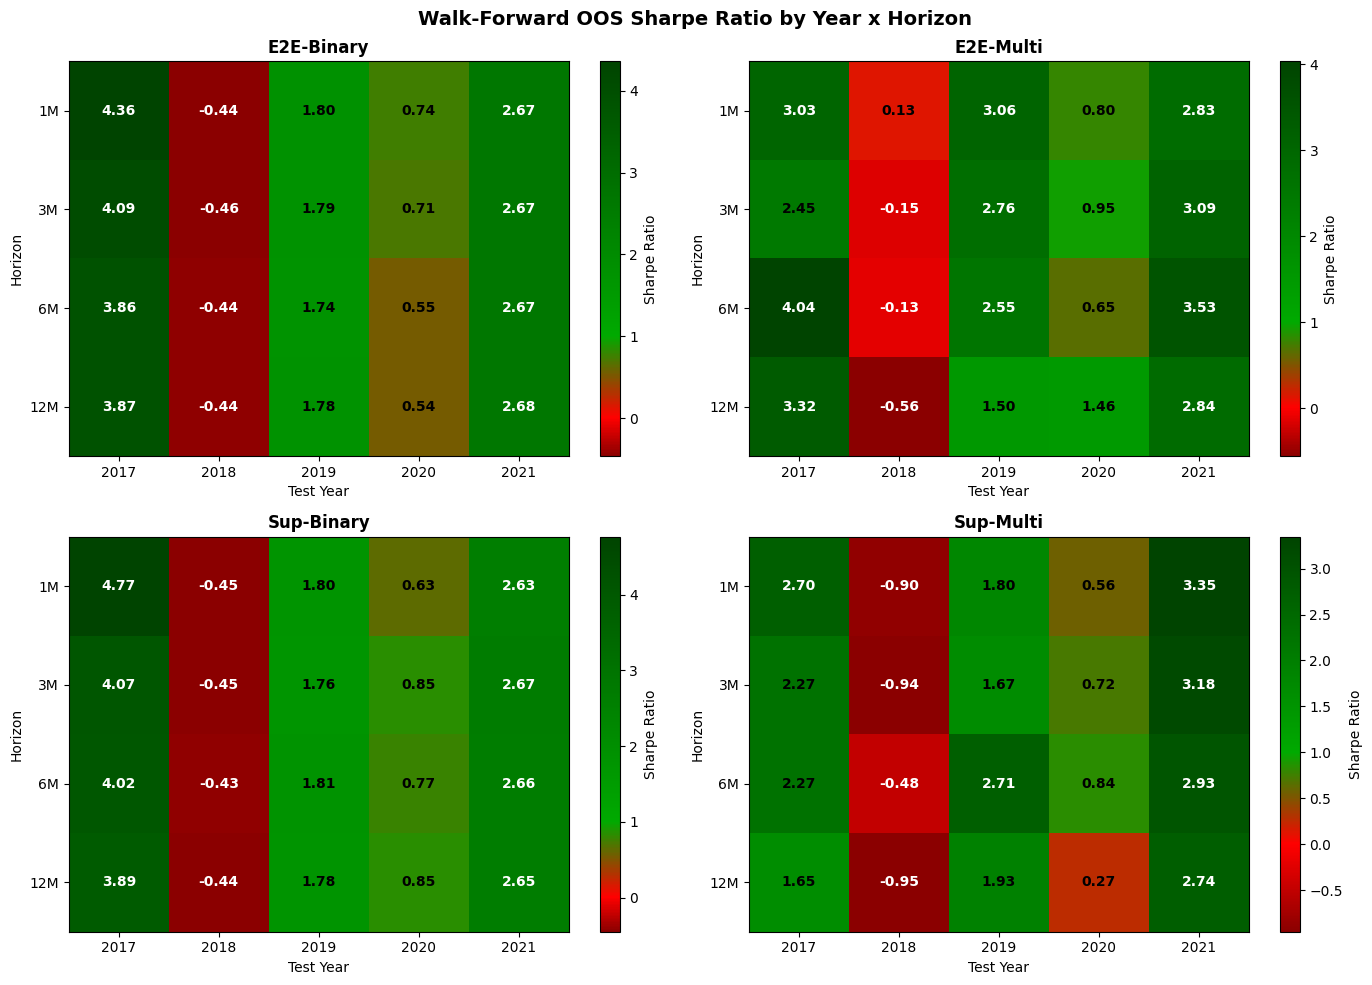

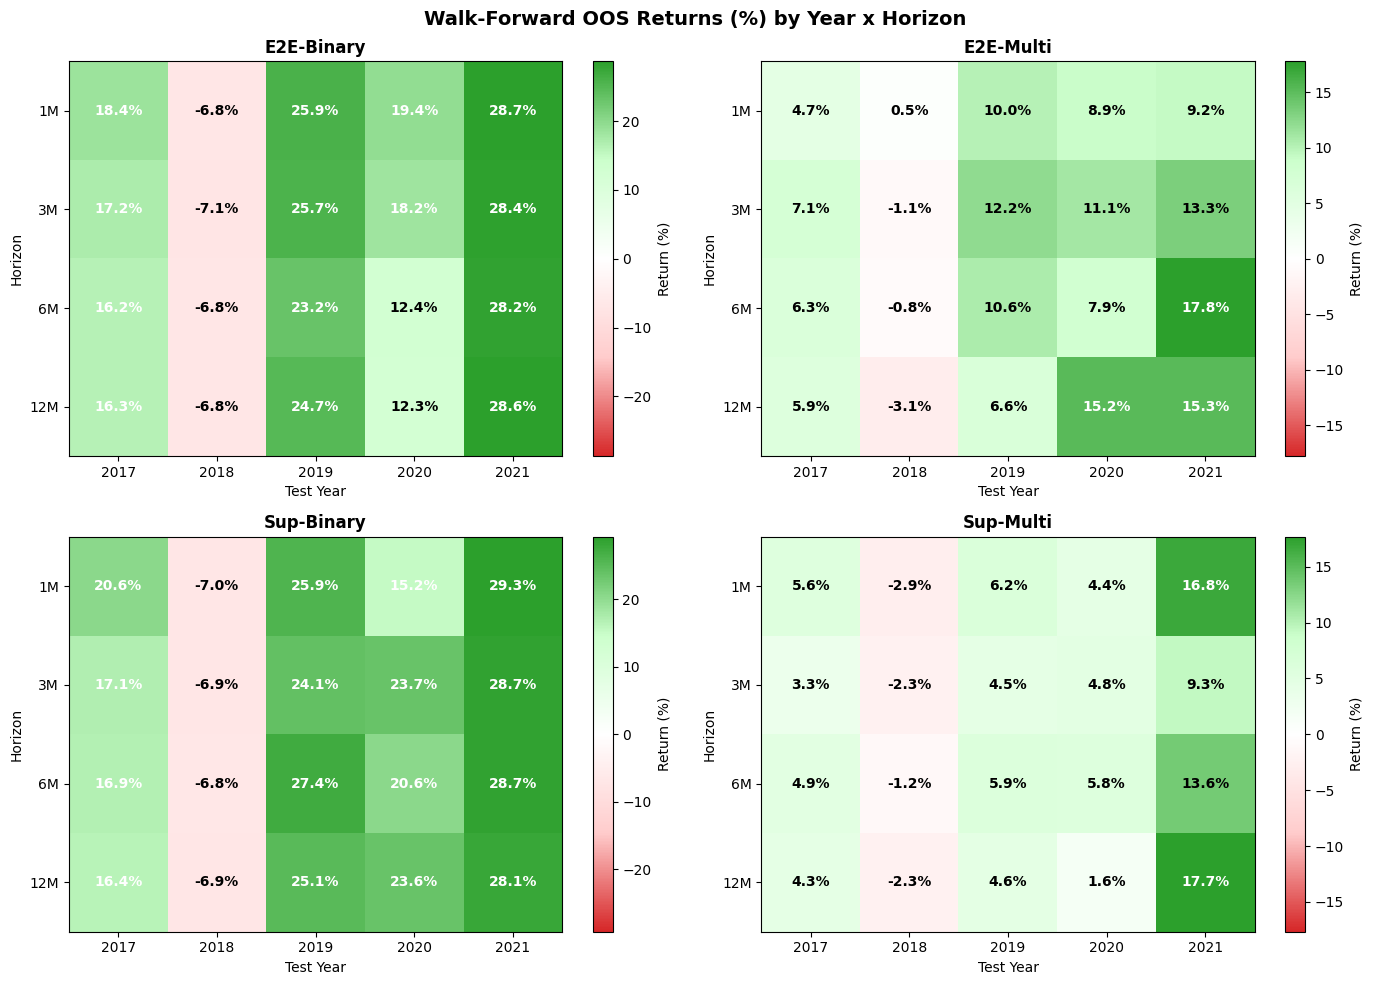

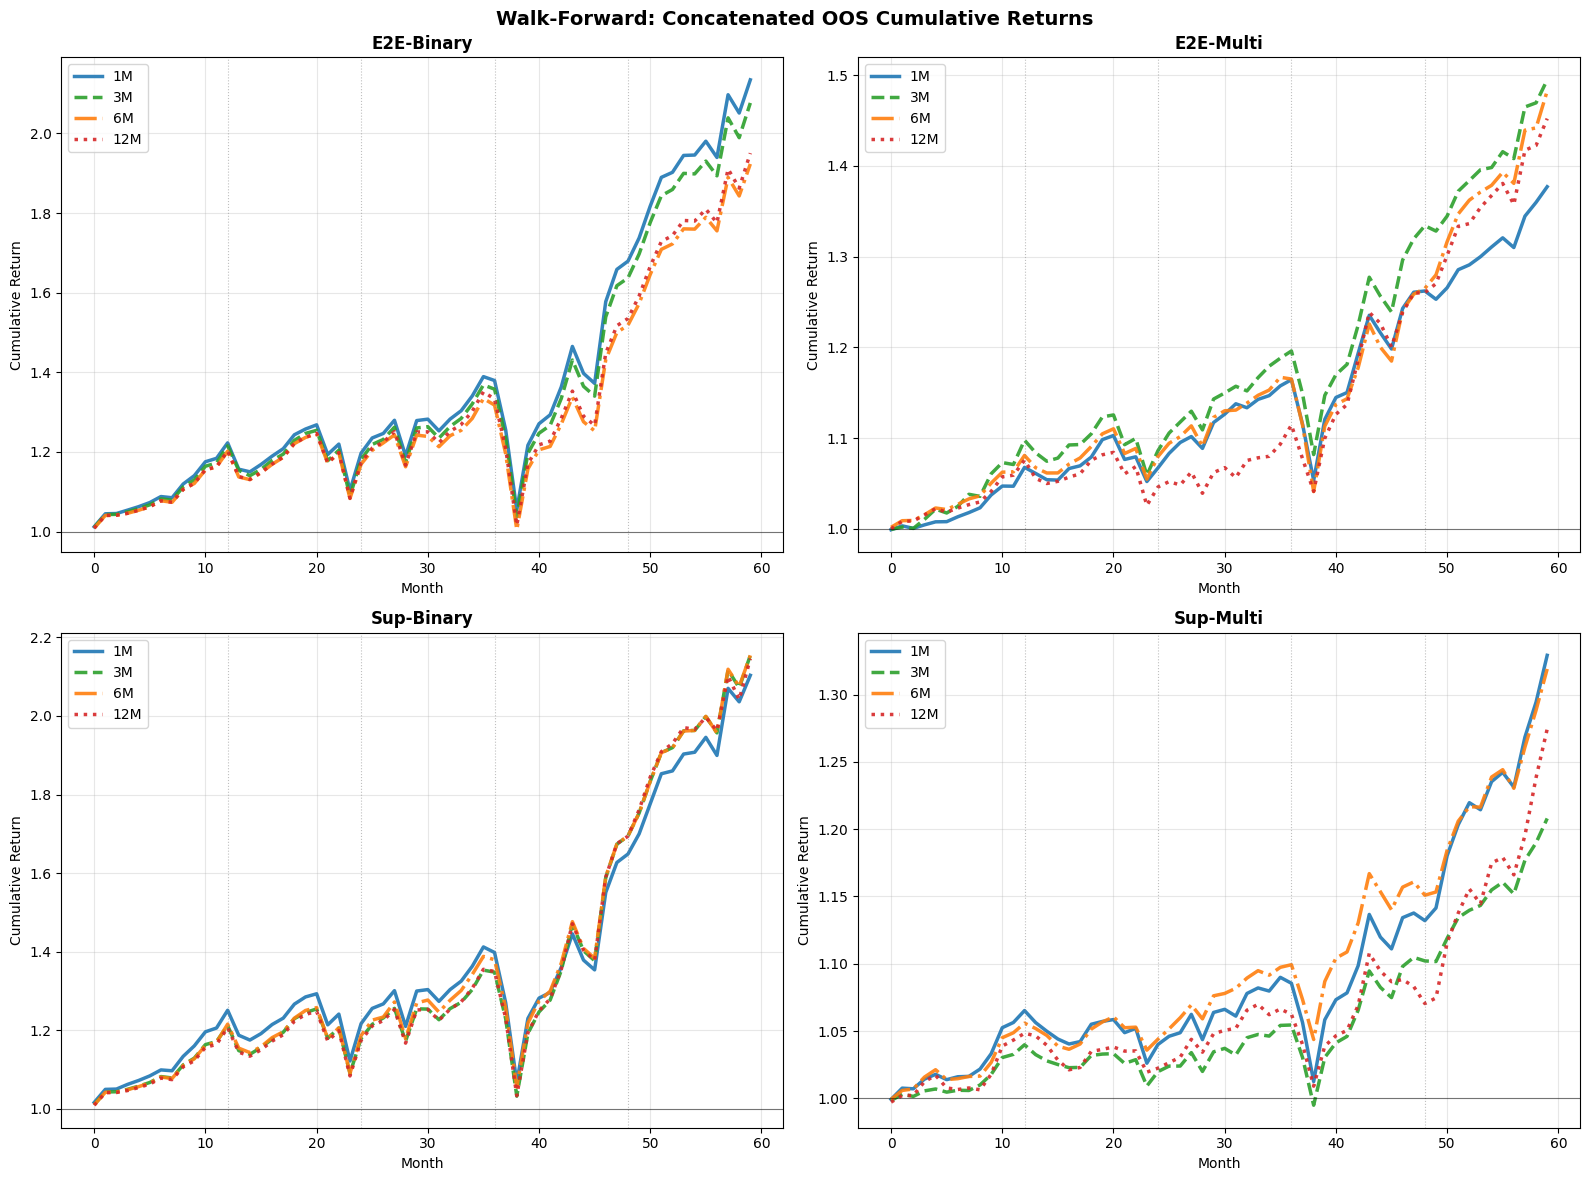

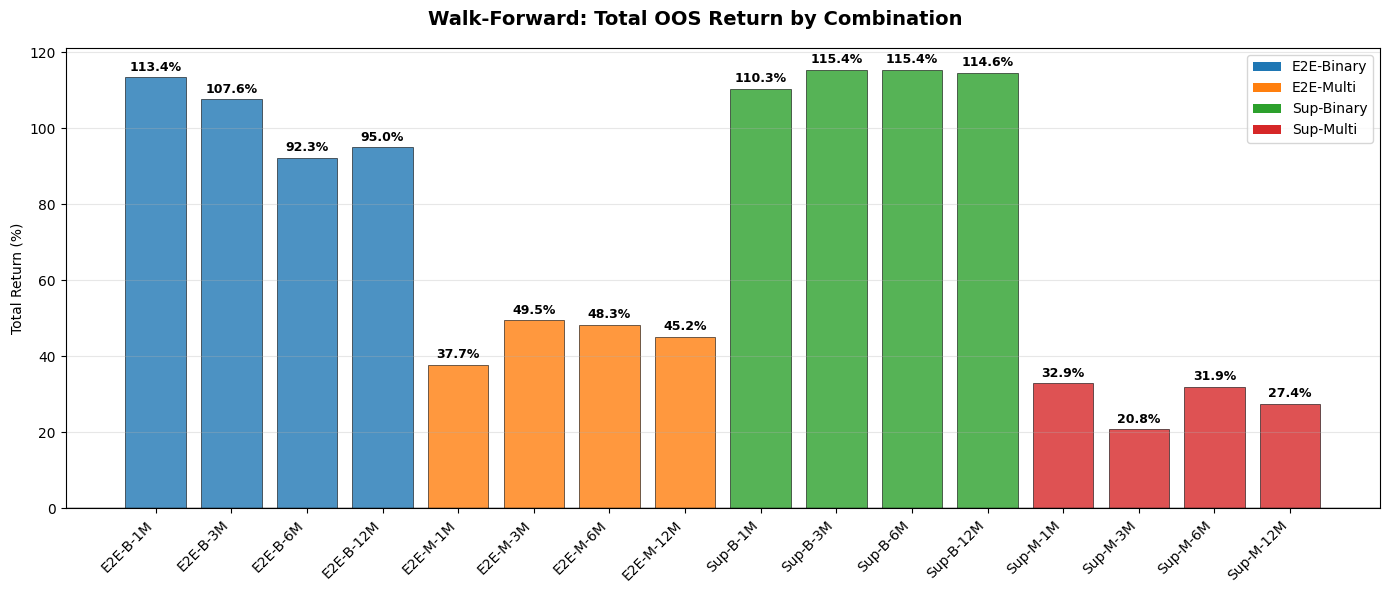

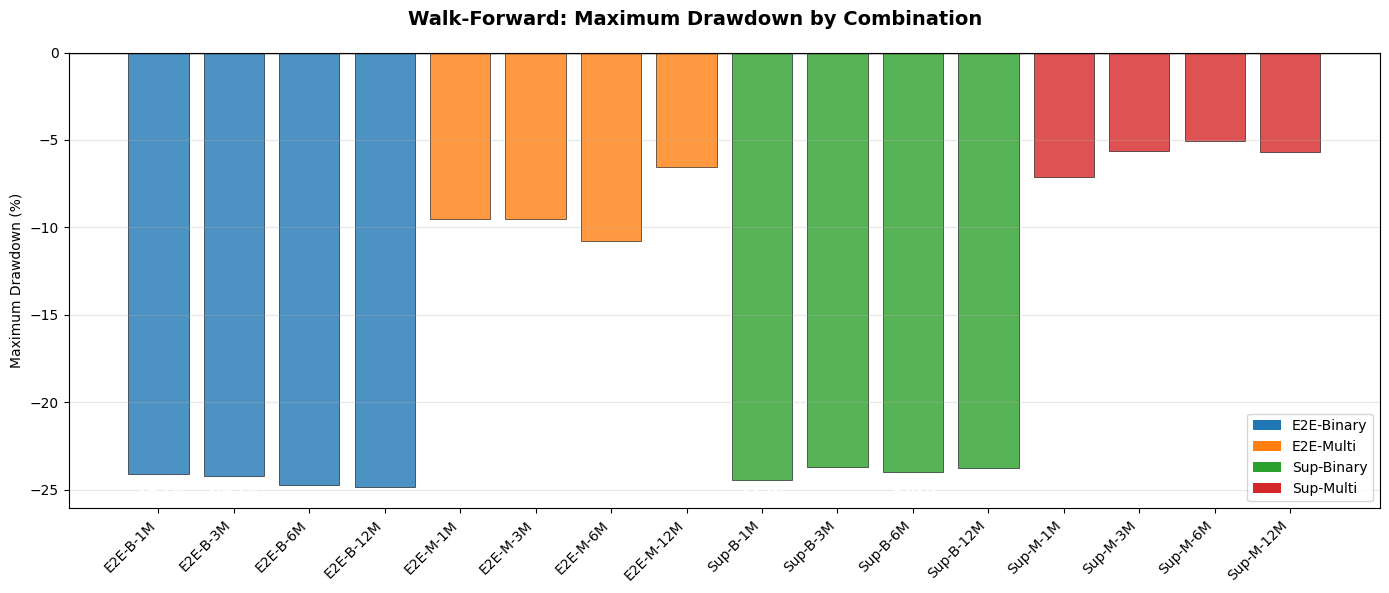


WALK-FORWARD SUMMARY BY YEAR

Combination             2017      2018      2019      2020      2021       TOTAL      MAX DD
--------------------------------------------------------------------------------------------
E2E-B-1M               +18.4%      -6.8%     +25.9%     +19.4%     +28.7%      +113.4%       -24.1%
E2E-B-3M               +17.2%      -7.1%     +25.7%     +18.2%     +28.4%      +107.6%       -24.2%
E2E-B-6M               +16.2%      -6.8%     +23.2%     +12.4%     +28.2%       +92.3%       -24.7%
E2E-B-12M              +16.3%      -6.8%     +24.7%     +12.3%     +28.6%       +95.0%       -24.8%
E2E-M-1M                +4.7%      +0.5%     +10.0%      +8.9%      +9.2%       +37.7%        -9.5%
E2E-M-3M                +7.1%      -1.1%     +12.2%     +11.1%     +13.3%       +49.5%        -9.5%
E2E-M-6M                +6.3%      -0.8%     +10.6%      +7.9%     +17.8%       +48.3%       -10.8%
E2E-M-12M               +5.9%      -3.1%      +6.6%     +15.2%     +15.3%       +45

[<Figure size 1400x1000 with 8 Axes>,
 <Figure size 1400x1000 with 8 Axes>,
 <Figure size 1600x1200 with 4 Axes>,
 <Figure size 1400x600 with 1 Axes>,
 <Figure size 1400x600 with 1 Axes>]

In [7]:
# ============================================================
# WALK-FORWARD VISUALIZATIONS
# ============================================================

from visualization import plot_all_walk_forward

plot_all_walk_forward(all_wf_results)

---
## STEP 2: Train Final Models (All 16 Combinations)

Train a single model on **all data except holdout** for each combination.

The holdout period is determined by the actual data range (last N years of available targets).

In [8]:
# ============================================================
# STEP 2: TRAIN FINAL MODELS
# ============================================================

evaluator.run_step2_final_models()
all_final_models = evaluator.final_models

print(f"\n{'=' * 80}")
print(f"STEP 2 COMPLETE: {sum(1 for v in all_final_models.values() if v is not None)}/16 models trained")
print("=" * 80)


STEP 2: TRAINING FINAL MODELS
Training period: 2000-01-01 to 2022-12-31
Training all 16 combinations...

[1/16] Training E2E + Binary @ 1M
  -> Model trained successfully
[2/16] Training E2E + Binary @ 3M
  -> Model trained successfully
[3/16] Training E2E + Binary @ 6M
  -> Model trained successfully
[4/16] Training E2E + Binary @ 12M
  -> Model trained successfully
[5/16] Training E2E + Multi @ 1M
  -> Model trained successfully
[6/16] Training E2E + Multi @ 3M
  -> Model trained successfully
[7/16] Training E2E + Multi @ 6M
  -> Model trained successfully
[8/16] Training E2E + Multi @ 12M
  -> Model trained successfully
[9/16] Training Sup + Binary @ 1M
  -> Model trained successfully
[10/16] Training Sup + Binary @ 3M
  -> Model trained successfully
[11/16] Training Sup + Binary @ 6M
  -> Model trained successfully
[12/16] Training Sup + Binary @ 12M
  -> Model trained successfully
[13/16] Training Sup + Multi @ 1M
  -> Model trained successfully
[14/16] Training Sup + Multi @ 3M


---
## STEP 3: Holdout Evaluation (All 16 Combinations)

Compare **Final Model** vs **Ensemble** on the holdout period for each combination:
- **Final Model**: Single model trained on all data except holdout
- **Ensemble**: Average predictions from N walk-forward models

Note: Different horizons have different holdout sizes due to forward-looking targets.

In [9]:
# ============================================================
# STEP 3: HOLDOUT EVALUATION
# ============================================================

evaluator.run_step3_holdout()
all_holdout_results = evaluator.holdout_results

# Print holdout summary
holdout_summary = evaluator._build_holdout_summary()
print("\n" + "=" * 120)
print("HOLDOUT RESULTS SUMMARY (with Composite Score)")
print("=" * 120)
print(f"\n{'Strategy':<8} {'Alloc':<7} {'H':<4} {'Type':<9} {'Sharpe':>10} {'IC':>10} {'MaxDD':>10} {'Score':>8} {'Rank':>6}")
print("-" * 90)

for _, row in holdout_summary.iterrows():
    print(f"{row['strategy']:<8} {row['allocation']:<7} {row['horizon']}M{'':<2} "
          f"{row['model_type']:<9} {row['sharpe']:>+10.4f} {row['ic']:>+10.4f} "
          f"{row['maxdd']:>+10.4f} {row['score']:>8.4f} {int(row['rank']):>6}")

print("=" * 120)

# Winner summary (Final vs Ensemble)
final_wins = sum(1 for _, row in holdout_summary.groupby(['strategy', 'allocation', 'horizon'])
                 if len(row) >= 2 and row[row['model_type'] == 'Final']['sharpe'].values[0] > 
                 row[row['model_type'] == 'Ensemble']['sharpe'].values[0])
ensemble_wins = sum(1 for _, row in holdout_summary.groupby(['strategy', 'allocation', 'horizon'])
                   if len(row) >= 2 and row[row['model_type'] == 'Ensemble']['sharpe'].values[0] > 
                   row[row['model_type'] == 'Final']['sharpe'].values[0])
ties = 16 - final_wins - ensemble_wins

print(f"\nFINAL vs ENSEMBLE: {final_wins} Final wins, {ensemble_wins} Ensemble wins, {ties} ties")
print("=" * 120)


STEP 3: HOLDOUT EVALUATION
Evaluating all 16 combinations on holdout period...
Holdout start: 2022-01-01


[1/16] E2E + Binary @ 1M

  Evaluating final model on holdout (2022-2024)...
  Holdout samples: 23
  Sharpe: +0.1368
  IC: -0.0550
  Total Return: +1.50%

  Ensemble evaluation (5 models) on holdout (2022-2024)...
  Holdout samples: 23
  Ensemble Sharpe: +0.1867
  Ensemble IC: -0.0033
  Ensemble Total Return: +3.41%

[2/16] E2E + Binary @ 3M

  Evaluating final model on holdout (2022-2024)...
  Holdout samples: 21
  Sharpe: +0.0277
  IC: +0.1575
  Total Return: -2.37%

  Ensemble evaluation (5 models) on holdout (2022-2024)...
  Holdout samples: 21
  Ensemble Sharpe: +0.1335
  Ensemble IC: -0.1704
  Ensemble Total Return: +1.39%

[3/16] E2E + Binary @ 6M

  Evaluating final model on holdout (2022-2024)...
  Holdout samples: 18
  Sharpe: +0.1564
  IC: +0.3448
  Total Return: +1.73%

  Ensemble evaluation (5 models) on holdout (2022-2024)...
  Holdout samples: 18
  Ensemble Sharpe:

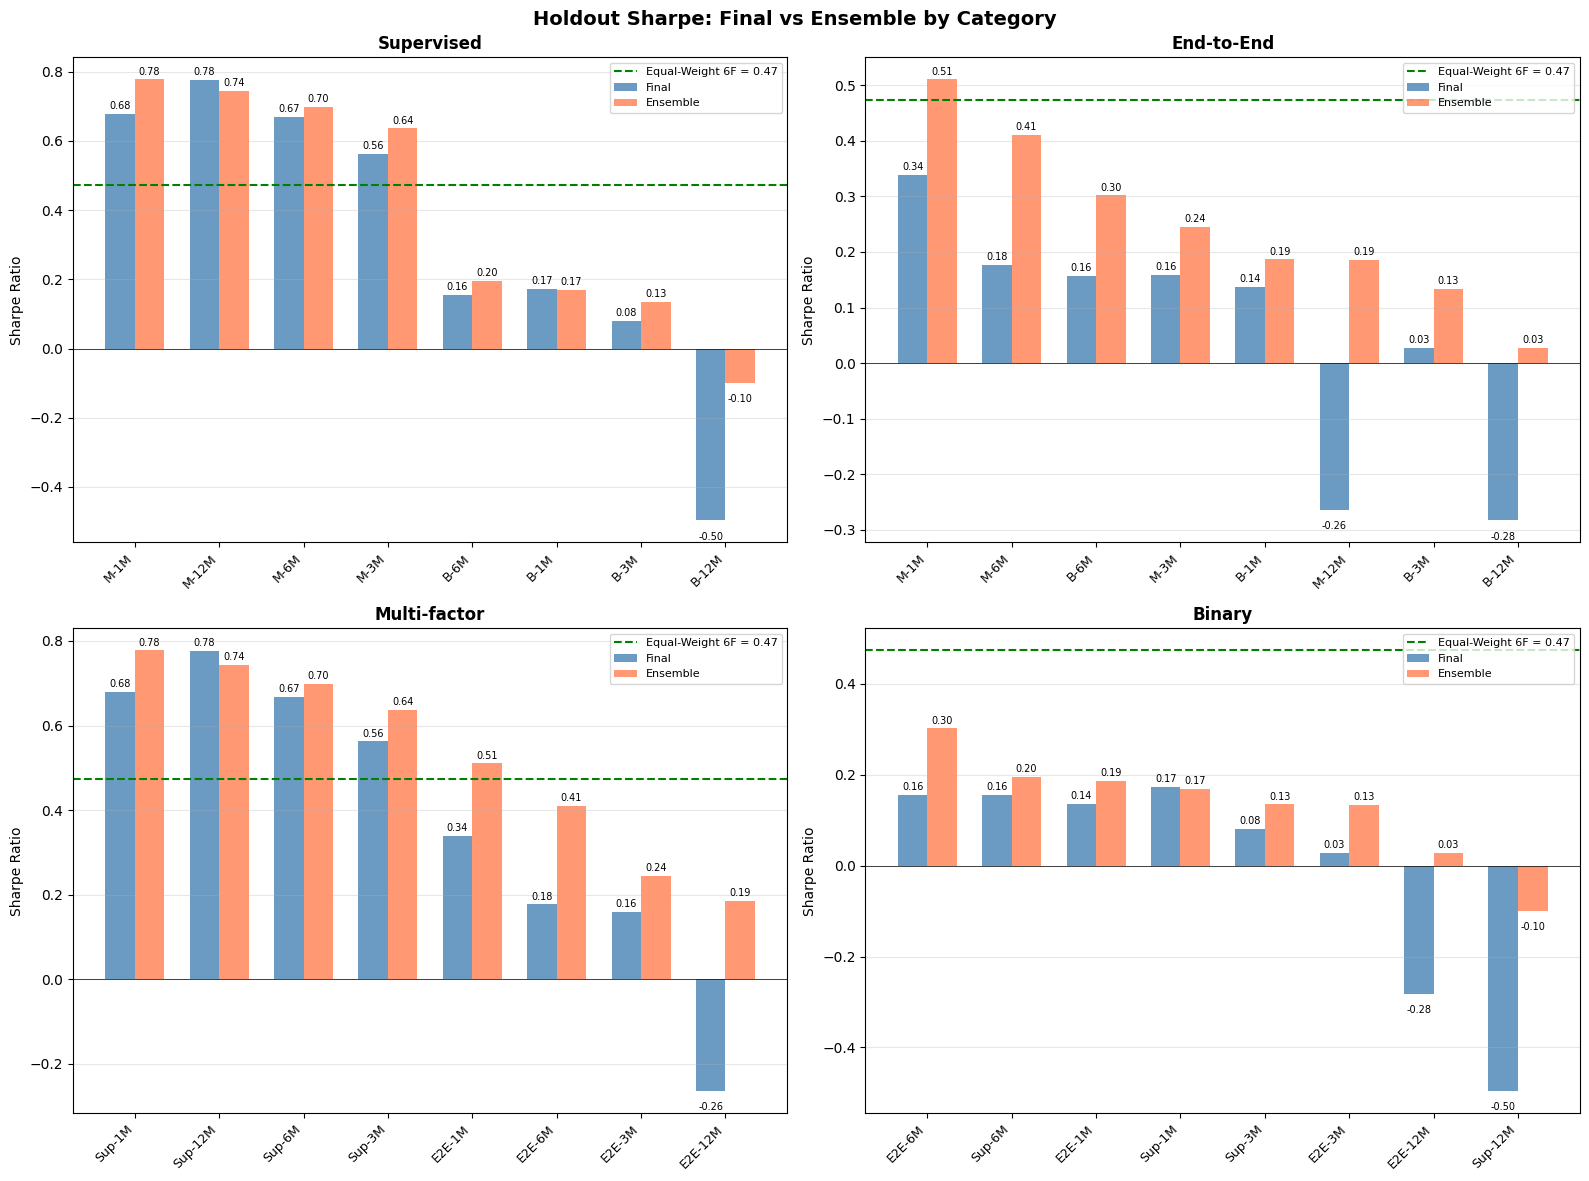

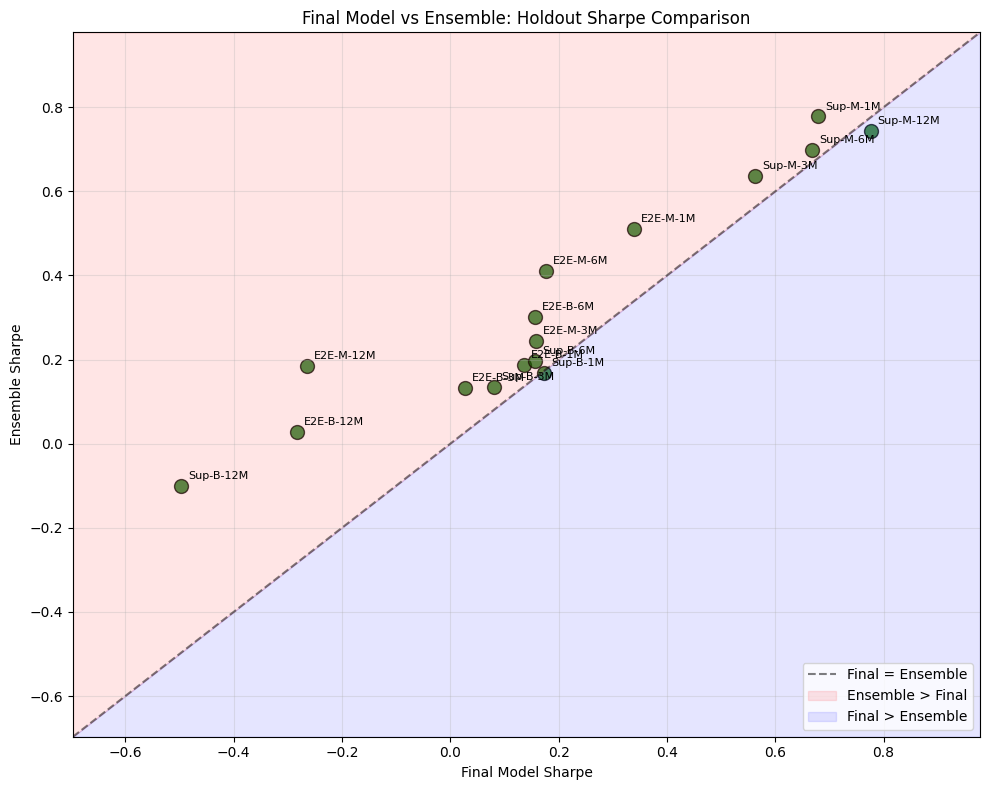

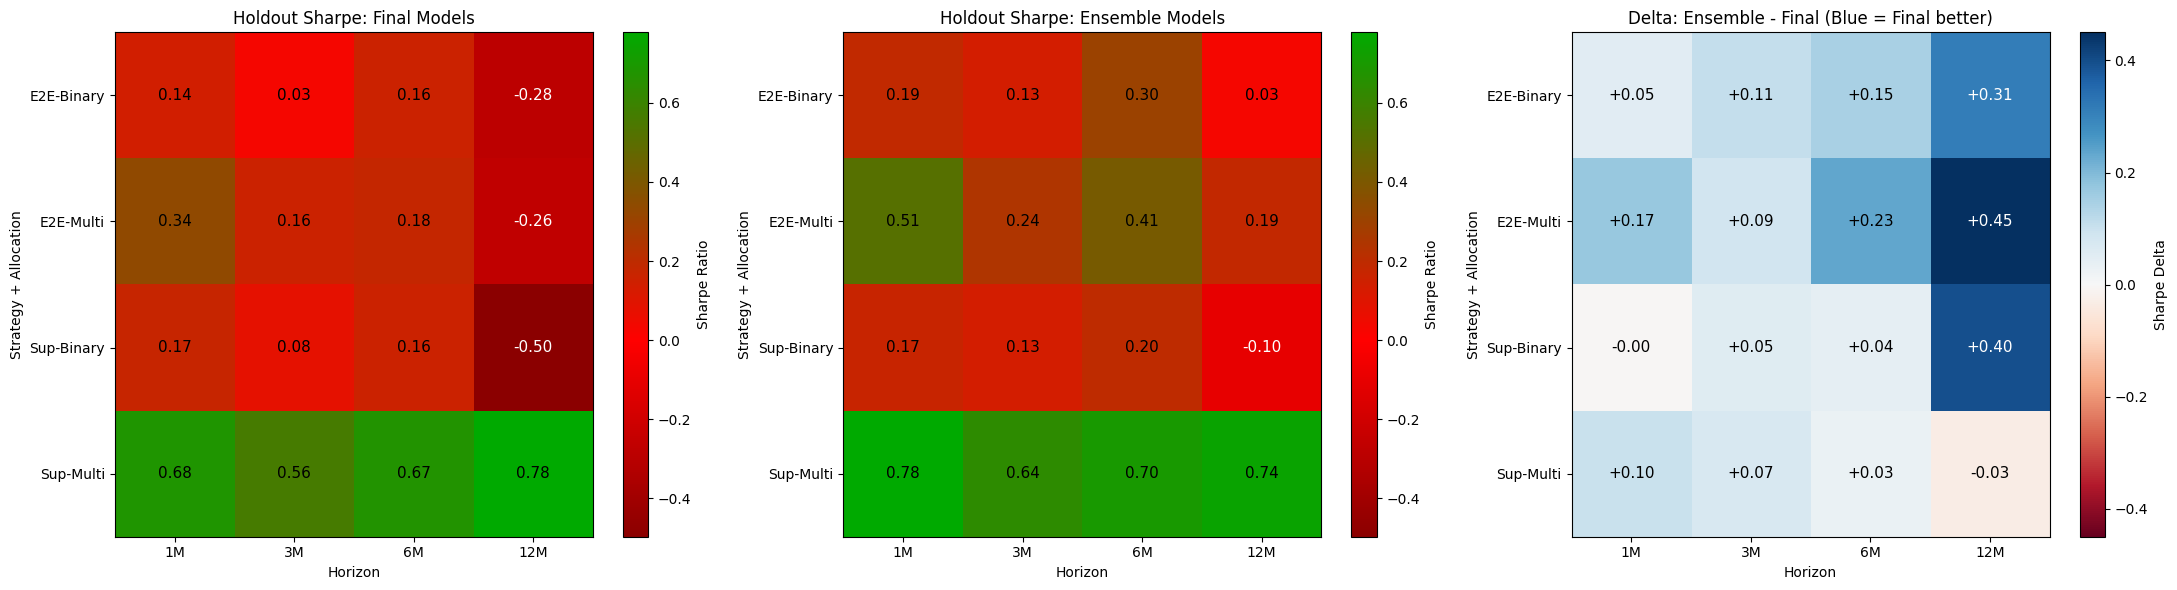

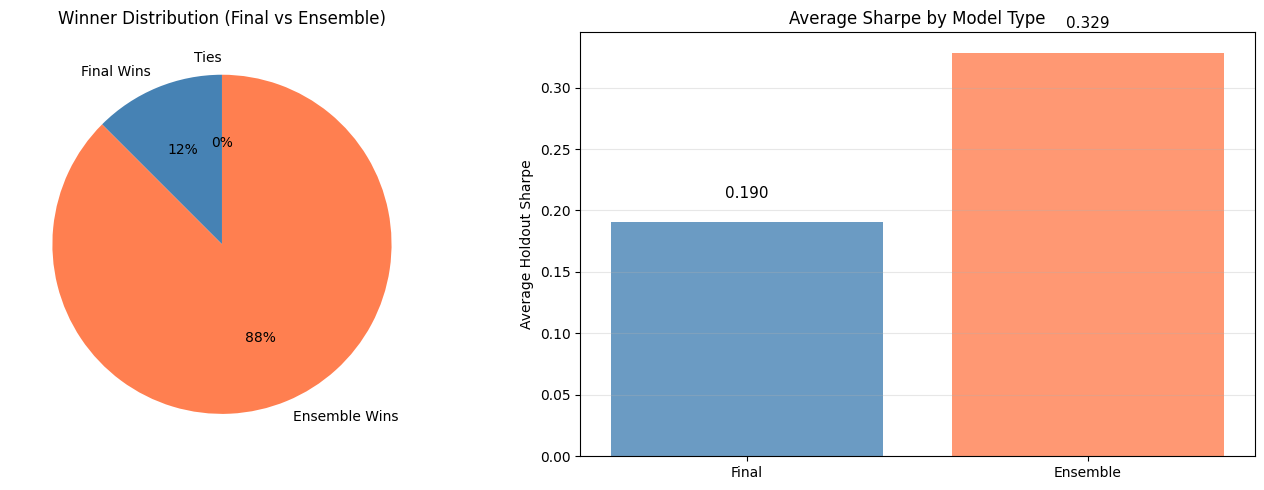

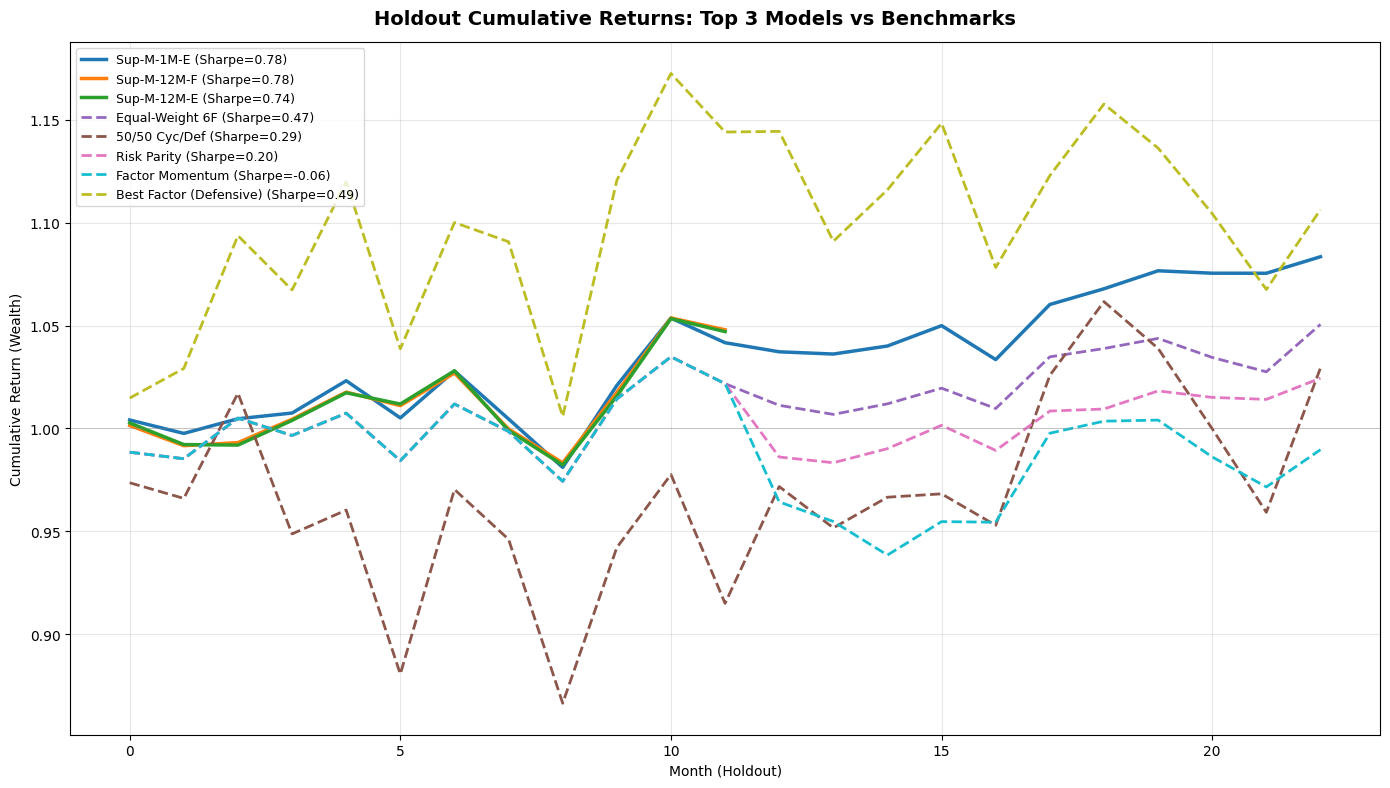


COMPLETE HOLDOUT RESULTS (with Composite Score)

Label              Strategy Alloc   H    Type           Sharpe       IC      MaxDD     Return    Score   Rank
------------------------------------------------------------------------------------------------------------------------
Sup-M-12M-E        Sup      Multi   12M   Ensemble      +0.7443  +0.2792    -0.0445     +4.71%   0.8396      1
Sup-M-1M-F         Sup      Multi   1M   Final         +0.6793  -0.0550    -0.0224     +7.20%   0.7890      2
Sup-M-1M-E         Sup      Multi   1M   Ensemble      +0.7779  +0.0066    -0.0456     +8.35%   0.7824      3
E2E-M-1M-E         E2E      Multi   1M   Ensemble      +0.5107  +0.1914    -0.0337     +5.24%   0.7697      4
Sup-M-6M-F         Sup      Multi   6M   Final         +0.6685  -0.1724    -0.0201     +5.26%   0.7626      5
Sup-M-3M-F         Sup      Multi   3M   Final         +0.5623  -0.1260    -0.0162     +4.28%   0.7493      6
Sup-M-3M-E         Sup      Multi   3M   Ensemble      +0.

[<Figure size 1600x1200 with 4 Axes>,
 <Figure size 1000x800 with 1 Axes>,
 <Figure size 2200x600 with 6 Axes>,
 <Figure size 1400x500 with 2 Axes>,
 <Figure size 1400x800 with 1 Axes>]

In [10]:
# ============================================================
# HOLDOUT VISUALIZATIONS
# ============================================================

from visualization import plot_all_holdout
from comparison_runner import compute_composite_score
from utils.benchmarks import compute_all_benchmarks

# Compute benchmarks for the holdout period
holdout_start = pd.Timestamp("2022-01-01")
benchmarks = compute_all_benchmarks(factor_data, start_date=holdout_start)

# Plot all holdout visualizations with benchmarks
plot_all_holdout(
    all_holdout_results,
    horizons=[1, 3, 6, 12],
    compute_score_fn=compute_composite_score,
    benchmarks=benchmarks,
)